# DA FARE:
- verificare nel paper Time-Frequency... se è giusto silenziare con il trim solo il training come ho scritto io.
- Le funzioni di questo notebook tipo upsamling e silence filtering le metterei in uno script .py.
- controlla batch size quanto deve essere 

###### La seguente implementazione seguirà quanto scritto nei paper:
"We train on the first 99 VCTK speakers and test on the 8 remaining ones" (in realtà sono 9 nel validation)

Visto che faremo fine-tuning sul task di single speaker, è importante sottolineare un aspetto. Il primo speaker (quello che serve nel task di single speaker), non può avere i dati del validation (nel task di single speaker) nel training del primo allenamento. Perciò, in questo notebook, si dovrà implementare un modo affinchè il validation del task di single speaker sia un'intersezione nulla con il training del task di multiple-speaker.

In [1]:
gdrive = True
import sys
if gdrive:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %tensorflow_version 1.x
    sys.path.append('/content/gdrive/My Drive/Tesi/src/')

Mounted at /content/gdrive
TensorFlow 1.x selected.


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import os, argparse
import numpy as np
import time
import h5py
import pickle
import librosa
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy.signal import decimate, butter, lfilter
import IPython.display as ipd
from scipy import signal
from ops import silence_filtering, upsample
from tqdm.notebook import tqdm
from keras.applications import MobileNet
from keras.models import Model
import re
from skimage.transform import resize
import librosa
from random import sample
import random
from dataset import DataSet
from training_ops import read_hdf5

Using TensorFlow backend.


In [ ]:
dimension = 8192 #--dimension -> dimension of patches --use -1 for no patching
sr = 16000 #args.sr -> audio sampling rate
scale = 4 #args.scale -> scaling factor
low_pass = True #args.low_pass -> apply low-pass filter when generating low-res patches
stride = 2048  #args.stride -> 8192*0.75 = 2048 (Time Frequency Networks For Audio Super-Resolu)
batch_size = 128 # sia tfnet che kuleshov usano 128
trim_silence = True
silence_trash = 0 #DA DEFINIRE

In [ ]:
def silence_filtering(sig, rmsenergy_treshold = 0.05, prob = 0.1):
    rmse = librosa.feature.rmse(y=sig, frame_length=256, hop_length=128)
    top_db = librosa.power_to_db(np.array([rmsenergy_treshold]), ref=np.max(rmse.squeeze()))
    filt_sig = librosa.effects.split(sig, top_db=-top_db, frame_length=256, hop_length=128)
    try:
        non_mute = sig[filt_sig[0][0]:filt_sig[len(filt_sig)-1][1]]
        if filt_sig[0][0] > 0: #if there is mute at the beginnig, I think it happen always
            mute_section_idx = np.array([0, filt_sig[0][0]])
            #with a probability = prob keep the silent part at the beginning
            mute = sig[mute_section_idx[0]:mute_section_idx[1]]
            v = random.uniform(0, 1)
            if v<= prob:
                out = np.concatenate([mute, non_mute])
            else:
                out = non_mute
        else:
            out = non_mute
    except:
        out = sig
    return out

In [ ]:
ROOT_DIR = os.path.dirname(os.path.abspath('.'))
out = os.path.join(ROOT_DIR, 'processedData', 'multispeaker', 'train&validation' + '\\')

In [ ]:
speaker1_id = 'p225'

In [ ]:
def from_txt_to_list(txt):
    out_list = []
    with open(txt) as f:
        for line in f:
            out_list.append(line.strip())
    return out_list

In [ ]:
def create_dir(directory):
    if not os.path.exists(directory):
        os.mkdir(directory)

In [ ]:
def create_data(how = 'training'): 
    txtfiles_dir = os.path.join(ROOT_DIR, 'processedData', 'txtfiles')
    if how == 'training':
        tr = True
        txt_list = os.path.join(txtfiles_dir, '{}-speakers-sampled.txt'.format('train'))
        speaker1_txt = os.path.join(txtfiles_dir, 'speaker1-{}-files.txt'.format('train'))
        fold1 = 'train' 
    elif how == 'validation':
        tr = False
        txt_list = os.path.join(txtfiles_dir, '{}-speakers-sampled.txt'.format('val'))
        speaker1_txt = os.path.join(txtfiles_dir, 'speaker1-{}-files.txt'.format('val'))
        fold1 = 'validation' 
    elif how == 'test':
        tr = False
        txt_list = os.path.join(txtfiles_dir, '{}-speakers.txt'.format('test'))
        speaker1_txt = os.path.join(txtfiles_dir, 'speaker1-{}-files.txt'.format('val'))
        fold1 = 'test' 
    else:
        raise ValueError('you should choose between training, validation or test')
        return None #necessario?
    
    id_list = from_txt_to_list(txt_list)
    speaker1_list = from_txt_to_list(speaker1_txt)
    file_list = []
    ID_list = []
    file_extensions = set(['.wav'])
    data_path = os.path.join(ROOT_DIR, 'rawData', 'VCTK-Corpus', 'wav48')
    for speaker_id in id_list:
        data_dir = os.path.join(data_path, speaker_id)
        for file in os.listdir(data_dir):
            filename = file.strip()
            ext = os.path.splitext(filename)[1]
            if (speaker_id == speaker1_id)&(filename not in speaker1_list):
                pass
            else:
                if ext in file_extensions:
                    file_list.append(os.path.join(data_dir, filename))
    
    h5_file = h5py.File(out + '{}_data.hdf5'.format(fold1), 'w')
    num_files = len(file_list)
    # patches to extract and their size
    d, d_lr = dimension, dimension
    s, s_lr = stride, stride
    hr_patches, lr_patches = list(), list()
    num_patches = 0
    file_name_diz = {}
    
    for j, file_path in enumerate(tqdm(file_list)):
        ID = int(re.search('p\d\d\d', file_path).group(0)[1:]) #originariamente era int(re.search('p\d\d\d/', file_path).group(0)[1:-1])
        # L'impostazione originale aveva due problemi. La regex ritornava un NoneType object, perciò è stato rimosso il backslash finale. 
        # Inoltre per ricavare l'ID dello speacker (es. p255 -> ID = 255), originariamente si aveva .group(0)[1:-1]. Tuttavia in quel caso veniva ID = 22 e non 225    

        # load audio file
        x, fs = librosa.load(file_path, sr=sr)
        
        if ((how == 'training')&(trim_silence == True)):
            x = silence_filtering(x, rmsenergy_treshold = 0.05, prob = 0.4)           
        
        # crop so that it works with scaling ratio
        x_len = len(x)
        x = x[ : x_len - (x_len % scale)] #sostanzialmente questa operazione permette di ottenere una lunghezza di x (numero di campioni) adeguata allo scaling ratio.
        # Es: scale = 2 -> se il numero di campioni (lunghezza di x) è pari, allora non succede nulla. Se è dispari, invece, l'ultimo campione viene rimosso. 

        # generate low-res version
        if low_pass:
            x_lr = decimate(x, scale)
        else:
            x_lr = np.array(x[0::scale]) # la lunghezza è pari a x/scale (approssimazione per eccesso). 
                                         # Sostanzialmente in questo modo si prendono campioni a salti. 
                                         # Es. a = np.arange(5)
                                         #     a[0::2] -> array([0, 2, 4])
        x_lr = upsample(x_lr, scale) #interpolate low-res patches with cubic splines. 
                                     #After this line of code len(x_lr) is equal to len(x)
        assert len(x) % scale == 0
        assert len(x_lr) == len(x)
        assert x.dtype == np.float32
        assert x_lr.dtype == np.float32

        # generate patches
        max_i = len(x) - d + 1
        n_patch_of_file = 0
        for i in range(0, max_i, s):
            i_lr = i
            hr_patch = np.array( x[i : i+d] )
            lr_patch = np.array( x_lr[i_lr : i_lr+d_lr] )

            assert len(hr_patch) == d
            assert len(lr_patch) == d_lr

            hr_patches.append(hr_patch.reshape((d,1)))
            lr_patches.append(lr_patch.reshape((d_lr,1)))
            ID_list.append(ID)
            
    num_patches = len(hr_patches)
    num_to_keep = int(np.floor(num_patches / batch_size) * batch_size)
    hr_patches = np.array(hr_patches[:num_to_keep])
    lr_patches = np.array(lr_patches[:num_to_keep])
    ID_list = ID_list[:num_to_keep]
    
    data_set_lr = h5_file.create_dataset('data_lr', lr_patches.shape, np.float32)
    data_set_lr[...] = lr_patches
    label_set = h5_file.create_dataset('label', hr_patches.shape, np.float32)
    label_set[...] = hr_patches
    
    file = open(out + 'ID_list_patches_' + str(d) + '_' + str(scale), 'wb')
    pickle.dump(ID_list, file)
    file.close()

In [ ]:
start_time = time.time()
create_data(how = 'training')
print("--- %s minutes ---" % ((time.time() - start_time)/60))


--- 83.93202962080638 minutes ---


### Sampling 
Potrebbe esserci un po di disordine nell'ordine delle celle. L'importnate è capire che nel training campiono 128896 patch e nel validation 30848

In [9]:
def sample_from_multidimensional_array(X, Y, how_many):
    n = X.shape[0]
    idx_tot = np.arange(n)
    idx_to_sample = np.random.choice(idx_tot, how_many, replace = False)
    return X[idx_to_sample, :, :], Y[idx_to_sample, :, :]

In [10]:
out = '/content/gdrive/My Drive/Tesi/processedData/multispeaker/train&validation/'

In [11]:
%%time
hf = h5py.File(out + 'train_data.hdf5', 'r')
X_tr, Y_tr = np.array(hf.get('data_lr')), np.array(hf.get('label'))

CPU times: user 1.85 s, sys: 10.5 s, total: 12.3 s
Wall time: 1min 22s


In [21]:
%%time
how_many = 128896
if X_tr.shape[0]>how_many:
    X_tr, Y_tr = sample_from_multidimensional_array(X_tr, Y_tr, how_many = how_many)

CPU times: user 1.13 s, sys: 7.22 s, total: 8.35 s
Wall time: 8.48 s


In [22]:
print(X_tr.shape)
assert (X_tr.shape[0] == how_many)
assert (X_tr.shape[0] % 128) == 0
assert (X_tr.shape[0] == Y_tr.shape[0])

(128896, 8192, 1)


In [23]:
%%time
h5_file = h5py.File(out + 'train_data_s.hdf5', 'w')
data_set_lr = h5_file.create_dataset('data_lr', X_tr.shape, np.float32)
data_set_lr[...] = X_tr
label_set = h5_file.create_dataset('label', X_tr.shape, np.float32)
label_set[...] = Y_tr
h5_file.close()

CPU times: user 209 ms, sys: 5.77 s, total: 5.98 s
Wall time: 59.8 s


In [ ]:
%%time
training_data = DataSet(X_tr, Y_tr, epochs_completed = 0)
for i in tqdm(range(int(X_tr.shape[0]/128))):
    training_data.next_batch(128)
print(training_data.epochs_completed)
training_data.next_batch(128)
print(training_data.epochs_completed)


0


In [15]:
out = '/content/gdrive/My Drive/Tesi/processedData/multispeaker/train&validation/'
hf_val = h5py.File(out + 'validation_data.hdf5', 'r')
X_val = np.array(hf_val.get('data_lr'))
Y_val = np.array(hf_val.get('label'))
how_many_val = 30848
if X_val.shape[0]>how_many_val:
    X_val, Y_val = sample_from_multidimensional_array(X_val, Y_val, how_many = how_many_val)

In [16]:
print(X_val.shape)
assert (X_val.shape[0] % 128) == 0
assert (X_val.shape[0] == Y_val.shape[0])

(30848, 8192, 1)


In [17]:
h5_file = h5py.File(out + 'validation_data_s.hdf5', 'w')
data_set_lr = h5_file.create_dataset('data_lr', X_val.shape, np.float32)
data_set_lr[...] = X_val
label_set = h5_file.create_dataset('label', X_val.shape, np.float32)
label_set[...] = Y_val
h5_file.close()

In [ ]:
validation_data = DataSet(X_val, Y_val, epochs_completed = 0)
for i in range(int(X_val.shape[0]/128)):
    validation_data.next_batch(128)
print(validation_data.epochs_completed)
validation_data.next_batch(128)
print(validation_data.epochs_completed)

0
1


### Fold Version

In [ ]:
def create_data_in_folders(how = 'training'): 
    txtfiles_dir = os.path.join(ROOT_DIR, 'processedData', 'txtfiles')
    if how == 'training':
        tr = True
        txt_list = os.path.join(txtfiles_dir, '{}-speakers.txt'.format('train'))
        speaker1_txt = os.path.join(txtfiles_dir, 'speaker1-{}-files.txt'.format('train'))
        fold1 = 'train' 
    elif how == 'validation':
        tr = False
        txt_list = os.path.join(txtfiles_dir, '{}-speakers.txt'.format('val'))
        speaker1_txt = os.path.join(txtfiles_dir, 'speaker1-{}-files.txt'.format('val'))
        fold1 = 'validation' 
    elif how == 'test':
        tr = False
        txt_list = os.path.join(txtfiles_dir, '{}-speakers.txt'.format('test'))
        speaker1_txt = os.path.join(txtfiles_dir, 'speaker1-{}-files.txt'.format('val'))
        fold1 = 'test' 
    else:
        raise ValueError('you should choose between training, validation or test')
        return None #necessario?
    
    id_list = from_txt_to_list(txt_list)
    speaker1_list = from_txt_to_list(speaker1_txt)
    file_list = []
    ID_list = []
    file_extensions = set(['.wav'])
    data_path = os.path.join(ROOT_DIR, 'rawData', 'VCTK-Corpus', 'wav48')
    for speaker_id in id_list:
        data_dir = os.path.join(data_path, speaker_id)
        for file in os.listdir(data_dir):
            filename = file.strip()
            ext = os.path.splitext(filename)[1]
            if (speaker_id == speaker1_id)&(filename not in speaker1_list):
                pass
            else:
                if ext in file_extensions:
                    file_list.append(os.path.join(data_dir, filename))
    
    out_dir = os.path.join(out, fold1, '')
    nested_out_dir_index = 1
    nested_out_dir = os.path.join(out_dir, str(nested_out_dir_index), '')
    create_dir(nested_out_dir)
    n_files_in_nested_out_dir = 0
    num_files = len(file_list)
    # patches to extract and their size
    d, d_lr = dimension, dimension
    s, s_lr = stride, stride
    num_patches = 0
    file_name_diz = {}
    
    for j, file_path in enumerate(tqdm(file_list)):
        ID = int(re.search('p\d\d\d', file_path).group(0)[1:]) #originariamente era int(re.search('p\d\d\d/', file_path).group(0)[1:-1])
        # L'impostazione originale aveva due problemi. La regex ritornava un NoneType object, perciò è stato rimosso il backslash finale. 
        # Inoltre per ricavare l'ID dello speacker (es. p255 -> ID = 255), originariamente si aveva .group(0)[1:-1]. Tuttavia in quel caso veniva ID = 22 e non 225    

        # load audio file
        x, fs = librosa.load(file_path, sr=sr)
        
        if ((how == 'training')&(trim_silence == True)):
            x = silence_filtering(x, rmsenergy_treshold = 0.05, prob = 0.1)           
        
        # crop so that it works with scaling ratio
        x_len = len(x)
        x = x[ : x_len - (x_len % scale)] #sostanzialmente questa operazione permette di ottenere una lunghezza di x (numero di campioni) adeguata allo scaling ratio.
        # Es: scale = 2 -> se il numero di campioni (lunghezza di x) è pari, allora non succede nulla. Se è dispari, invece, l'ultimo campione viene rimosso. 

        # generate low-res version
        if low_pass:
            x_lr = decimate(x, scale)
        else:
            x_lr = np.array(x[0::scale]) # la lunghezza è pari a x/scale (approssimazione per eccesso). 
                                         # Sostanzialmente in questo modo si prendono campioni a salti. 
                                         # Es. a = np.arange(5)
                                         #     a[0::2] -> array([0, 2, 4])
        x_lr = upsample(x_lr, scale) #interpolate low-res patches with cubic splines. 
                                     #After this line of code len(x_lr) is equal to len(x)
        assert len(x) % scale == 0
        assert len(x_lr) == len(x)
        assert x.dtype == np.float32
        assert x_lr.dtype == np.float32

        # generate patches
        max_i = len(x) - d + 1
        n_patch_of_file = 0
        for i in range(0, max_i, s):
            i_lr = i
            hr_patch = np.array( x[i : i+d] )
            lr_patch = np.array( x_lr[i_lr : i_lr+d_lr] )

            assert len(hr_patch) == d
            assert len(lr_patch) == d_lr

            hr_patch.reshape((1,d,1))
            lr_patch.reshape((1,d_lr,1))
            n_patch_of_file += 1
            file_name = '{}_{}_{}.hdf5'.format(ID, j, n_patch_of_file)
            h5_file = h5py.File(nested_out_dir + file_name, 'w')
            data_set_lr = h5_file.create_dataset('data_lr', lr_patch.shape, np.float32)
            data_set_lr[...] = lr_patch
            label_set = h5_file.create_dataset('label', hr_patch.shape, np.float32)
            label_set[...] = hr_patch
            n_files_in_nested_out_dir += 1
            file_name_diz[file_name] = {'fold1':fold1, 'nested_fold':nested_out_dir_index}
            if n_files_in_nested_out_dir == 500:
                n_files_in_nested_out_dir= 0
                nested_out_dir_index += 1
                nested_out_dir = os.path.join(out_dir, str(nested_out_dir_index), '')
                create_dir(nested_out_dir)
                n_files_in_nested_out_dir = 0
            num_patches += 1
            ID_list.append(ID)
            
    # Devo eliminare dalla cartella i file in eccesso (affinchè il numero totale di file sia multiplo di batch_size).
    num_to_keep = int(np.floor(num_patches / batch_size) * batch_size)
    to_remove = num_patches - num_to_keep
    if to_remove > 0:
        files_to_remove = sample(file_name_diz.keys(), to_remove)
        for key in files_to_remove:
            nested_fold = file_name_diz[key]['nested_fold']
            os.remove(os.path.join(out_dir,str(nested_fold),key))
            del file_name_diz[key]
        print('Sono stati rimossi correttamente {} file'.format(to_remove))
    ID_list = ID_list[:num_to_keep]

    file = open(out + 'file_list_' + how, 'wb')
    pickle.dump(file_name_diz, file)
    file.close()
    
    file = open(out + 'ID_list_patches_' + str(d) + '_' + str(scale), 'wb')
    pickle.dump(ID_list, file)
    file.close()

# Altro 

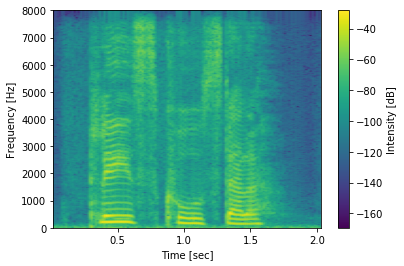

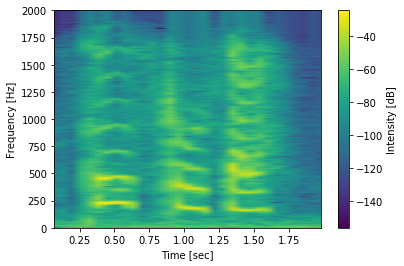

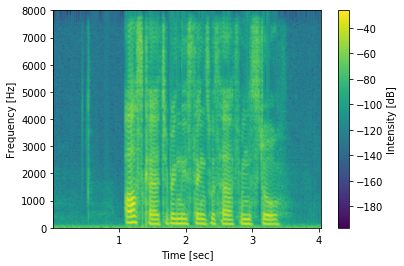

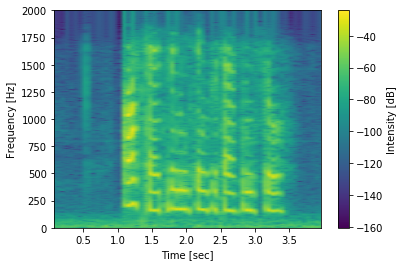

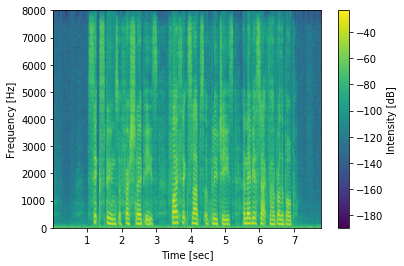

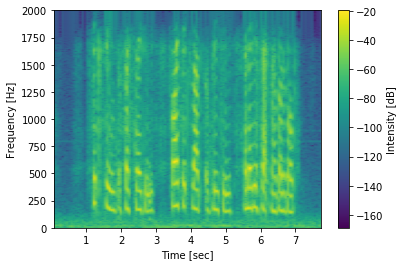

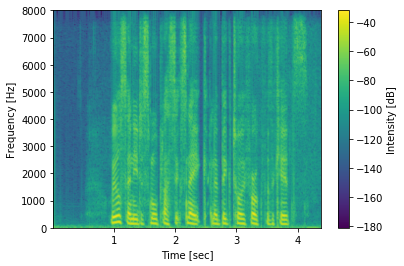

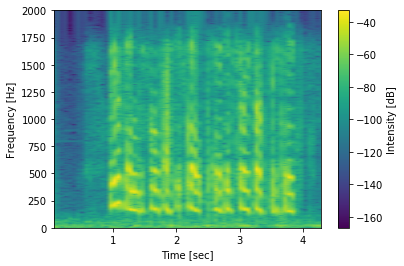

In [ ]:
from evaluation_ops import *
data_path = os.path.join(ROOT_DIR, 'rawData', 'VCTK-Corpus', 'wav48')
data_dir = os.path.join(data_path, 'p225')
for i, file in enumerate(os.listdir(data_dir)):
    filename = file.strip()
    file_path = os.path.join(data_dir, filename)
    x, fs = librosa.load(file_path, sr=sr)
    librosa.feature.rmse(y=x)
    plot_stft_spectogram(x)
    x_lr = decimate(x, 4)
    plot_stft_spectogram(x_lr, rate = int(16000/4))
    if i == 3:
        break

In [ ]:
file_path = 'C:\\Users\\Giobi\\Tesi\\rawData\\VCTK-Corpus\\wav48\\p225\\p225_005.wav'

In [ ]:
x, fs = librosa.load(file_path, sr=sr, dtype = 'float32')

In [ ]:
filt_sig

array([[15744, 17792],
       [19840, 20608],
       [20736, 20864],
       [20992, 21632],
       [21888, 22016],
       [26240, 26624],
       [26752, 26880],
       [29312, 29696],
       [35840, 37376],
       [42496, 42752],
       [44672, 44928],
       [48512, 49536],
       [52224, 53248],
       [59904, 60032],
       [60160, 60544]])

In [ ]:
import random
random.uniform(0, 1)

0.0970437872900014

In [ ]:
import IPython.display as ipd
print(librosa.get_duration(x))
ipd.Audio(x, rate = fs)

4.740770975056689


In [ ]:
x_trim = silence_filtering(x, 0.05, prob = 0.2)
print(librosa.get_duration(x_trim))
ipd.Audio(x_trim, rate = fs)

2.9315192743764173


In [ ]:
mse = librosa.feature.rmse(y=x, frame_length=256, hop_length=128)**2
rmse = librosa.feature.rmse(y=x, frame_length=256, hop_length=128)

In [ ]:
# import librosa.display
# frames = range(len(mse))
# t = librosa.frames_to_time(frames, sr=sr, hop_length=256)
# librosa.display.waveplot(x, sr=sr, alpha=0.4)
# plt.plot(t, mse/mse.max(), 'r--') # normalized for visualization
# plt.plot(t[:len(rmse)], rmse/rmse.max(), color='g') # normalized for visualization
# plt.legend(('MSE', 'RMSE'))

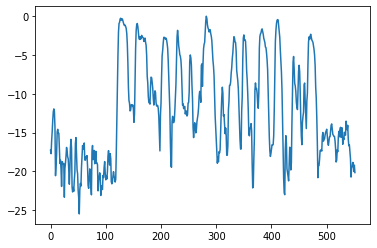

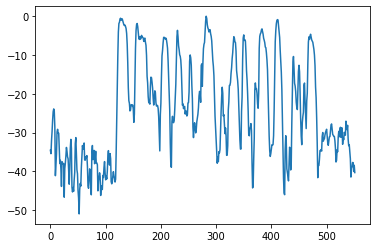

In [ ]:
plt.plot(librosa.power_to_db(rmse.squeeze(), ref=np.max)); plt.show()
plt.plot(librosa.power_to_db(mse.squeeze(), ref=np.max)); plt.show()

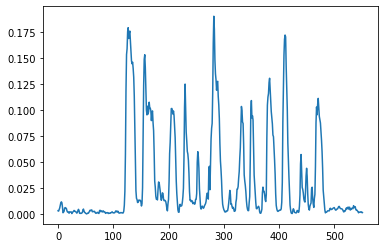

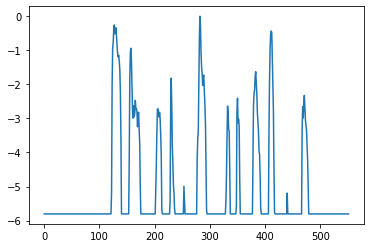

In [ ]:
plt.plot(rmse.squeeze()); plt.show()
top_db = librosa.power_to_db(np.array([0.05]), ref=np.max(rmse.squeeze()))
plt.plot(librosa.power_to_db(rmse.squeeze(), ref=np.max, top_db=-top_db)); plt.show()

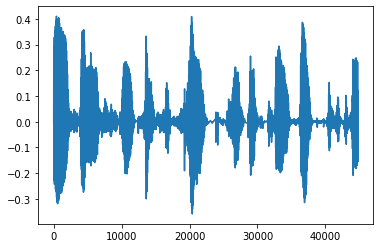

2.0317460317460316


In [ ]:
x_trim = silence_filtering(x, -top_db)
plt.plot(x_trim); plt.show()
print(librosa.get_duration(x_trim))
ipd.Audio(x_trim, rate = fs)

In [ ]:
filt_sig = librosa.effects.split(x, top_db=-top_db[0], frame_length=256, hop_length=128)

In [ ]:
nonzero_idx = filt_sig

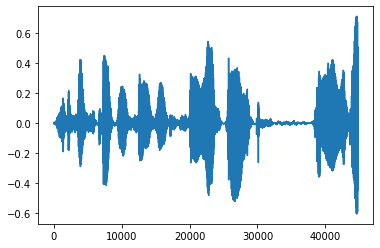

In [ ]:
plt.plot(x[filt_sig[0][0]:filt_sig[len(filt_sig)-1][1]]);

In [ ]:
ipd.Audio(x[filt_sig[0][0]:filt_sig[14][1]], rate = fs)

In [ ]:
reconstructed_sig = np.array([])
for i in range(len(filt_sig)):
    reconstructed_sig = np.concatenate([reconstructed_sig, x[filt_sig[i][0]:filt_sig[i][1]]])

In [ ]:
len(x_trim)

44800

In [ ]:
len(reconstructed_sig)

9216

In [ ]:
ipd.Audio(reconstructed_sig, rate = fs)

In [ ]:
len(x[filt_sig[14][0]:filt_sig[14][1]])

384

In [ ]:
filt_sig

array([[15744, 17792],
       [19840, 20608],
       [20736, 20864],
       [20992, 21632],
       [21888, 22016],
       [26240, 26624],
       [26752, 26880],
       [29312, 29696],
       [35840, 37376],
       [42496, 42752],
       [44672, 44928],
       [48512, 49536],
       [52224, 53248],
       [59904, 60032],
       [60160, 60544]])

In [ ]:
nonzero_idx[0]

array([15744, 17792])